# Installing Scikit Learn

In [4]:
!pip3 install -U scikit-learn scipy matplotlib

Requirement already up-to-date: scipy in c:\users\nilsvn\appdata\local\programs\python\python36-32\lib\site-packages (1.4.1)
Requirement already up-to-date: matplotlib in c:\users\nilsvn\appdata\local\programs\python\python36-32\lib\site-packages (3.2.1)
Could not build wheels for scipy, since package 'wheel' is not installed.
Could not build wheels for matplotlib, since package 'wheel' is not installed.
Could not build wheels for numpy, since package 'wheel' is not installed.
Could not build wheels for cycler, since package 'wheel' is not installed.
Could not build wheels for kiwisolver, since package 'wheel' is not installed.
Could not build wheels for python-dateutil, since package 'wheel' is not installed.
Could not build wheels for pyparsing, since package 'wheel' is not installed.
Could not build wheels for six, since package 'wheel' is not installed.


You should consider upgrading via the 'c:\users\nilsvn\appdata\local\programs\python\python36-32\python.exe -m pip install --upgrade pip' command.


In [58]:
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn import naive_bayes
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import time
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
import warnings
warnings.filterwarnings('ignore')

In [59]:
def get_df(normal_path, attack_path_1a, attack_path_1b, attack_path_2a, attack_path_2b):
    df_normal = pd.read_csv(normal_path)
    df_attack_1 = pd.concat([pd.read_csv(attack_path_1a), 
                             pd.read_csv(attack_path_1b)], ignore_index=True)

    df_attack_2 = pd.concat([pd.read_csv(attack_path_2a), 
                             pd.read_csv(attack_path_2b)], ignore_index=True)
    
    df_normal['Class'] = 0 #create new 'Class' column containing only 0's
    df_attack_1['Class'] = 1 #create new 'Class' column containing only 1's
    df_attack_2['Class'] = 1 #create new 'Class' column containing only 1's
    
    # feel free to change the amount depending on the amount of RAM you have (max 16,906)
    df_normal_1 = df_normal.head(5000)
    df_normal_2 = df_normal.tail(5000)
    
    df_train = pd.concat([df_attack_1, df_normal_1], ignore_index=True)
    df_test = pd.concat([df_attack_2, df_normal_2], ignore_index=True)
    return df_train, df_test

In [60]:
def get_X_y(df):
    X = df.drop('Class', axis=1)
    y = df['Class']
    return X, y

In [61]:
def datetime_string_to_epoch(str):
    format = '%Y-%m-%d %H:%M:%S'
    if str[10] == 'T':
        format = '%Y-%m-%dT%H:%M:%S'
    t = time.strptime(str[:19], format)
    return time.mktime(t)

IPAddress/TimeGenerated/UserPrincipalName

In [62]:
# create dictionary where IPAddress points to dictionary, containing time_epoch
# as keys, which each point to one account this IP successfully logged into
def get_nested_dict_user_name_qty_from_ip_in_window(df):
    res_dict = {}
    ip_addr_list = df['IPAddress'].values.tolist()
    time_gen_list = df['TimeGenerated'].values.tolist()
    user_name_list = df['UserPrincipalName'].values.tolist()
    access_list = df['ConditionalAccessStatus'].values.tolist()
    
    for i in range(0, len(ip_addr_list)):
        val_dict = res_dict.setdefault(ip_addr_list[i], {})
        if (access_list[i] == 'success'):
            val_dict[time_gen_list[i]] = user_name_list[i]
    return res_dict

In [63]:
def diff_acc_same_ip_in_window(df, delta_s, res_dict):
    length = df['TimeGenerated'].size # total rows in data frame
    
    # go by each row in dataset
    for i in range(0, length):
        ip_addr = df['IPAddress'][i]
        time_gen = df['TimeGenerated'][i]
        time_acc_dict = res_dict[ip_addr]
        
        # save the amount of different accounts this IP successfully
        # logged into in a certain time window (delta_s)
        accs = []
        for time_key in time_acc_dict.keys():
            if (time_gen - delta_s) < time_key < (time_gen + delta_s):
                acc = time_acc_dict[time_key]
                if (acc not in accs):
                    accs.append(acc)
        df['UserPrincipalName'][i] = len(accs)

Location/TimeGenerated/UserPrincipalName

In [64]:
# create dictionary where UserPrincipalName points to dictionary, containing time_epoch
# as keys, which each point to one Location this account was logged in from
def get_nested_dict_acc_locations_in_window(df):
    res_dict = {}
    location_list = df['Location'].values.tolist()
    time_gen_list = df['TimeGenerated'].values.tolist()
    user_name_list = df['UserPrincipalName'].values.tolist()
    access_list = df['ConditionalAccessStatus'].values.tolist()
    
    for i in range(0, len(location_list)):
        val_dict = res_dict.setdefault(user_name_list[i], {})
        if (access_list[i] == 'success'):
            val_dict[time_gen_list[i]] = location_list[i]
    return res_dict

In [65]:
def diff_loc_same_acc_in_window(df, loc_delta_s, loc_dict):
    length = df['TimeGenerated'].size # total rows in data frame
    
    # go by each row in dataset
    for i in range(0, length):
        user_name = df['UserPrincipalName'][i]
        time_gen = df['TimeGenerated'][i]
        time_loc_dict = loc_dict[user_name]
        
        # save the amount of different locations from which this account was successfully
        # logged into within a certain time window (loc_delta_s) into column 'Location'
        locs = []
        for time_key in time_loc_dict.keys():
            if (time_gen - loc_delta_s) < time_key < (time_gen + loc_delta_s):
                loc = time_loc_dict[time_key]
                if (loc not in locs):
                    locs.append(loc)
        # print(str(user_name) + ' = ' +  str(locs))
        df['Location'][i] = len(locs)

In [66]:
def preprocess_data(df):
    # filter to keep most relevant columns
    df = df[['IPAddress', 'UserPrincipalName', 'Location',
             'TimeGenerated', 'ConditionalAccessStatus', 'Class']]
    # convert datetime strings to epoch
    df['TimeGenerated'] = df['TimeGenerated'].map(datetime_string_to_epoch)
    
    # tweak the (location) time window as necessary (time +/- in seconds)
    loc_delta_s = 1800
    
    # for each row, save the amount of different locations from which this account was successfully
    # logged into within a certain time window (loc_delta_s) into column 'Location'
    loc_dict = get_nested_dict_acc_locations_in_window(df)
    diff_loc_same_acc_in_window(df, loc_delta_s, loc_dict)
    
    # tweak the time window as necessary (time +/- in seconds)
    delta_s = 120
    
    # for each row, save the amount of different accounts this IP successfully logged
    # into within a certain time window (delta_s) into column 'UserPrincipalName'
    res_dict = get_nested_dict_user_name_qty_from_ip_in_window(df)
    diff_acc_same_ip_in_window(df, delta_s, res_dict)
    
    # split Pandas DataFrame into X (data) and y (corresponding class labels)
    X, y = get_X_y(df)
    
    # One-Hot Encoding for the nominal categorical variables
    X = pd.get_dummies(data=X, columns=['ConditionalAccessStatus'])
    
    # Standardization of values
    scaler = MinMaxScaler()
    X[['UserPrincipalName', 'Location']] = scaler.fit_transform(
                                X[['UserPrincipalName', 'Location']])
    
    # Deletion of 'TimeGenerated' and 'IPAddress' as they were only needed for feature extraction (time windows)
    del X['TimeGenerated']
    del X['IPAddress']
    print(X.head(15))
    # print(X)
    
    return X, y

In [67]:
def thres_from_to_qty(fr, to, qty):
    qty -= 1
    res = [fr]
    diff = to - fr
    for i in range(1, qty + 1):
        res.append(fr + (i * diff) / qty)
    return res
        
    

In [83]:
def plot_metrics(thres_list, acc_list, prc_list, rec_list, thres_from, thres_to, txt):
    plt.rcParams["font.family"] = "Times New Roman"
    font_size = 18
    
    plt.plot(thres_list, acc_list, "k-")
    plt.plot(thres_list, prc_list, "k--")
    plt.plot(thres_list, rec_list, "k:")
    plt.axis([thres_from, thres_to, 0, 1])
    plt.xlabel('Threshold', fontsize=font_size)
    plt.ylabel('ACC, PRC, REC', fontsize=font_size)
    plt.xticks(fontsize=font_size)
    plt.yticks(fontsize=font_size)
    
    plt.legend(['ACC', 'PRC', 'REC'], loc='upper right', fontsize = 14)
    
    plt.figtext(0.05, -0.1, txt, wrap=True, horizontalalignment='left', fontsize=font_size)

    ax = plt.gca()
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    
    plt.show()

In [69]:
# change these file paths when reproducing results
# files are available on my github: https://github.com/NilsvN/my_thesis
NORMAL_PATH = "C:/Users/NilsvN/.jupyter/home/my_thesis/datasets/30days_anonymized_sigin_logs_column_corrected.csv"
ATTACK_PATH_1A = "C:/Users/NilsvN/.jupyter/home/my_thesis/datasets/valid_accounts_same_ip_1.csv"
ATTACK_PATH_1B = "C:/Users/NilsvN/.jupyter/home/my_thesis/datasets/valid_accounts_diff_loc_1.csv"
ATTACK_PATH_2A = "C:/Users/NilsvN/.jupyter/home/my_thesis/datasets/valid_accounts_same_ip_2.csv"
ATTACK_PATH_2B = "C:/Users/NilsvN/.jupyter/home/my_thesis/datasets/valid_accounts_diff_loc_2.csv"

In [70]:
pd.set_option('display.max_rows', None)

# create df's from csv data
df_train, df_test = get_df(NORMAL_PATH, ATTACK_PATH_1A, ATTACK_PATH_1B, 
                                        ATTACK_PATH_2A, ATTACK_PATH_2B)
X_train, y_train = preprocess_data(df_train)
X_test, y_test = preprocess_data(df_test)

    UserPrincipalName  Location  ConditionalAccessStatus_failure  \
0            0.666667       0.5                                0   
1            0.666667       0.5                                0   
2            0.333333       1.0                                0   
3            0.333333       1.0                                0   
4            0.333333       1.0                                0   
5            0.333333       1.0                                0   
6            0.333333       0.5                                0   
7            0.333333       0.5                                0   
8            0.333333       0.5                                0   
9            0.333333       0.5                                0   
10           0.333333       0.5                                0   
11           0.333333       0.5                                0   
12           0.333333       0.5                                0   
13           0.333333       0.5                 

# SVM:

In [97]:
def SVM(X_train, X_test, y_train, y_test, threshold):
    model = svm.SVC(kernel='linear', probability=True)
    model.fit(X_train, y_train)
    y_pred = (model.predict_proba(X_test)[:,1] >= threshold).astype(bool)
    
    # print(metrics.confusion_matrix(y_test, y_pred))
    # print(metrics.classification_report(y_test, y_pred, digits=3))
    
    ACC = metrics.accuracy_score(y_test, y_pred)
    PRC = metrics.precision_score(y_test, y_pred) # when multiclass: average=None
    REC = metrics.recall_score(y_test, y_pred) # when multiclass: average=None
    return ACC, PRC, REC

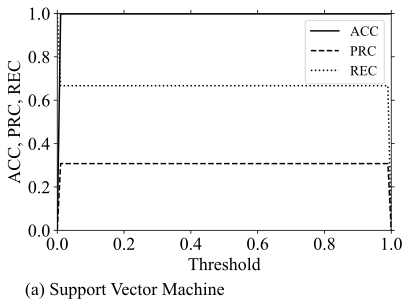

In [98]:
# feel free to tweak as necessary
thres_from = 0
thres_to = 1
thres_qty = 100

# preparing data for plotting
thres_list = thres_from_to_qty(thres_from, thres_to, thres_qty)
acc_list = []
prc_list = []
rec_list = []

for thres in thres_list:
    acc, prc, rec = SVM(X_train, X_test, y_train, y_test, thres)
    acc_list.append(acc)
    prc_list.append(prc)
    rec_list.append(rec)
plot_metrics(thres_list, acc_list, prc_list, rec_list, thres_from, thres_to, "(a) Support Vector Machine")

# Naive Bayes:

In [99]:
def naive_bayes_gaussian(X_train, X_test, y_train, y_test, threshold):
    model = naive_bayes.GaussianNB()
    model.fit(X_train, y_train)
    y_pred = (model.predict_proba(X_test)[:,1] >= threshold).astype(bool)
    #y_pred = model.predict(X_test)
    
    # print(metrics.confusion_matrix(y_test, y_pred))
    # print(metrics.classification_report(y_test, y_pred, digits=3))
    
    ACC = metrics.accuracy_score(y_test, y_pred)
    PRC = metrics.precision_score(y_test, y_pred) # when multiclass: average=None
    REC = metrics.recall_score(y_test, y_pred) # when multiclass: average=None
    return ACC, PRC, REC
    

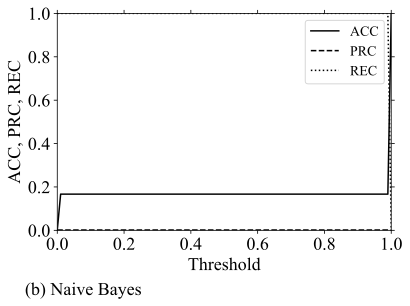

In [100]:
# feel free to tweak as necessary
thres_from = 0
thres_to = 1
thres_qty = 100

# preparing data for plotting
thres_list = thres_from_to_qty(thres_from, thres_to, thres_qty)
acc_list = []
prc_list = []
rec_list = []

for thres in thres_list:
    acc, prc, rec = naive_bayes_gaussian(X_train, X_test, y_train, y_test, thres)
    acc_list.append(acc)
    prc_list.append(prc)
    rec_list.append(rec)
plot_metrics(thres_list, acc_list, prc_list, rec_list, thres_from, thres_to, "(b) Naive Bayes")

# K-Nearest Neighbours

In [101]:
def k_nearest_neighbours(X_train, X_test, y_train, y_test, neighbours):
    model = KNeighborsClassifier(neighbours)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # print(metrics.confusion_matrix(y_test, y_pred))
    # print(metrics.classification_report(y_test, y_pred, digits=3))
    
    ACC = metrics.accuracy_score(y_test, y_pred)
    PRC = metrics.precision_score(y_test, y_pred) # when multiclass: average=None
    REC = metrics.recall_score(y_test, y_pred) # when multiclass: average=None
    return ACC, PRC, REC

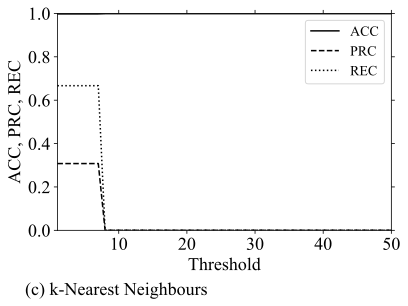

In [102]:
# feel free to tweak as necessary
thres_from = 1
thres_to = 50
thres_qty = 50

# preparing data for plotting
thres_list = thres_from_to_qty(thres_from, thres_to, thres_qty)
acc_list = []
prc_list = []
rec_list = []

for thres in thres_list:
    thres = int(thres)
    acc, prc, rec = k_nearest_neighbours(X_train, X_test, y_train, y_test, thres)
    acc_list.append(acc)
    prc_list.append(prc)
    rec_list.append(rec)
plot_metrics(thres_list, acc_list, prc_list, rec_list, thres_from, thres_to, "(c) k-Nearest Neighbours")

# Decision Trees

In [103]:
def decision_trees(X_train, X_test, y_train, y_test, threshold):
    model = DecisionTreeClassifier()
    model.fit(X_train, y_train)
    y_pred = (model.predict_proba(X_test)[:,1] >= threshold).astype(bool)
    #y_pred = model.predict(X_test)
    
    # print(metrics.confusion_matrix(y_test, y_pred))
    # print(metrics.classification_report(y_test, y_pred, digits=3))
    
    ACC = metrics.accuracy_score(y_test, y_pred)
    PRC = metrics.precision_score(y_test, y_pred) # when multiclass: average=None
    REC = metrics.recall_score(y_test, y_pred) # when multiclass: average=None
    return ACC, PRC, REC

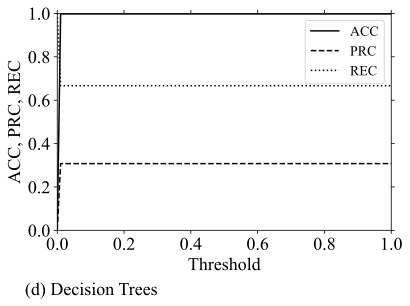

In [104]:
# feel free to tweak as necessary
thres_from = 0
thres_to = 1
thres_qty = 100

# preparing data for plotting
thres_list = thres_from_to_qty(thres_from, thres_to, thres_qty)
acc_list = []
prc_list = []
rec_list = []

for thres in thres_list:
    acc, prc, rec = decision_trees(X_train, X_test, y_train, y_test, thres)
    acc_list.append(acc)
    prc_list.append(prc)
    rec_list.append(rec)
plot_metrics(thres_list, acc_list, prc_list, rec_list, thres_from, thres_to, "(d) Decision Trees")

# Logistic Regression

In [105]:
def logistic_regression(X_train, X_test, y_train, y_test, threshold):
    model = LogisticRegression()
    model.fit(X_train, y_train)
    y_pred = (model.predict_proba(X_test)[:,1] >= threshold).astype(bool)
    #y_pred = model.predict(X_test)
    
    # print(metrics.confusion_matrix(y_test, y_pred))
    # print(metrics.classification_report(y_test, y_pred, digits=3))
    
    ACC = metrics.accuracy_score(y_test, y_pred)
    PRC = metrics.precision_score(y_test, y_pred) # when multiclass: average=None
    REC = metrics.recall_score(y_test, y_pred) # when multiclass: average=None
    return ACC, PRC, REC

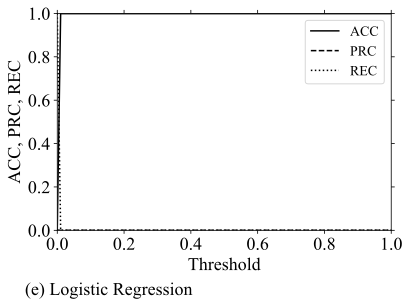

In [106]:
# feel free to tweak as necessary
thres_from = 0
thres_to = 1
thres_qty = 100

# preparing data for plotting
thres_list = thres_from_to_qty(thres_from, thres_to, thres_qty)
acc_list = []
prc_list = []
rec_list = []

for thres in thres_list:
    acc, prc, rec = logistic_regression(X_train, X_test, y_train, y_test, thres)
    acc_list.append(acc)
    prc_list.append(prc)
    rec_list.append(rec)
plot_metrics(thres_list, acc_list, prc_list, rec_list, thres_from, thres_to, "(e) Logistic Regression")

# Linear Discriminant Analysis

In [107]:
def linear_discriminant_analysis(X_train, X_test, y_train, y_test, threshold):
    model = LinearDiscriminantAnalysis()
    model.fit(X_train, y_train)
    y_pred = (model.predict_proba(X_test)[:,1] >= threshold).astype(bool)
    #y_pred = model.predict(X_test)
    
    # print(metrics.confusion_matrix(y_test, y_pred))
    # print(metrics.classification_report(y_test, y_pred, digits=3))
    
    ACC = metrics.accuracy_score(y_test, y_pred)
    PRC = metrics.precision_score(y_test, y_pred) # when multiclass: average=None
    REC = metrics.recall_score(y_test, y_pred) # when multiclass: average=None
    return ACC, PRC, REC

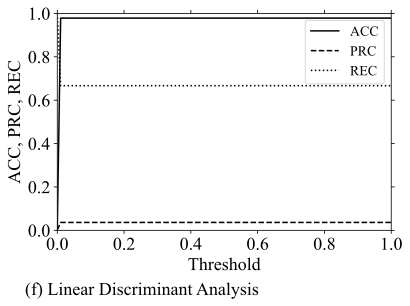

In [108]:
# feel free to tweak as necessary
thres_from = 0
thres_to = 1
thres_qty = 100

# preparing data for plotting
thres_list = thres_from_to_qty(thres_from, thres_to, thres_qty)
acc_list = []
prc_list = []
rec_list = []

for thres in thres_list:
    acc, prc, rec = linear_discriminant_analysis(X_train, X_test, y_train, y_test, thres)
    acc_list.append(acc)
    prc_list.append(prc)
    rec_list.append(rec)
plot_metrics(thres_list, acc_list, prc_list, rec_list, thres_from, thres_to, "(f) Linear Discriminant Analysis")